In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from imblearn.over_sampling import SMOTE
import shap

In [2]:
data_path = "/content/employee_productivity.csv"
data = pd.read_csv(data_path)

In [3]:
data.columns = data.columns.str.strip()

In [4]:
print("\nDescriptive Statistics:\n", data.describe())
print("\nMissing Values:\n", data.isnull().sum())


Descriptive Statistics:
         Experience  Training_Hours  Work_Life_Balance  Team_Dynamics  \
count  1000.000000     1000.000000        1000.000000    1000.000000   
mean     15.448000       49.615500           3.034000       5.687100   
std       9.243957       14.905275           1.410969       2.569822   
min       0.000000       10.000000           1.000000       1.000000   
25%       7.000000       39.650000           2.000000       3.500000   
50%      16.000000       49.850000           3.000000       5.800000   
75%      24.000000       59.300000           4.000000       7.900000   
max      30.000000       94.500000           5.000000      10.000000   

       Environment_Score      Team_ID  Productivity_Score  
count        1000.000000  1000.000000         1000.000000  
mean            5.338900    10.349000          337.358600  
std             2.600488     5.801625           73.706242  
min             1.000000     1.000000           36.500000  
25%             3.100000 

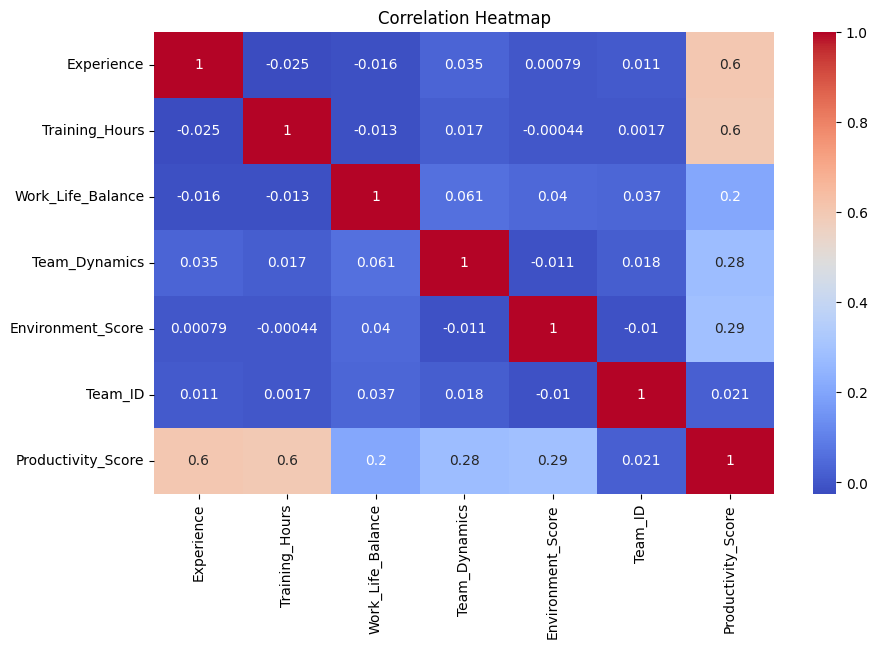

In [5]:
plt.figure(figsize=(10, 6))
numerical_data = data.select_dtypes(include=[np.number])
sns.heatmap(numerical_data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

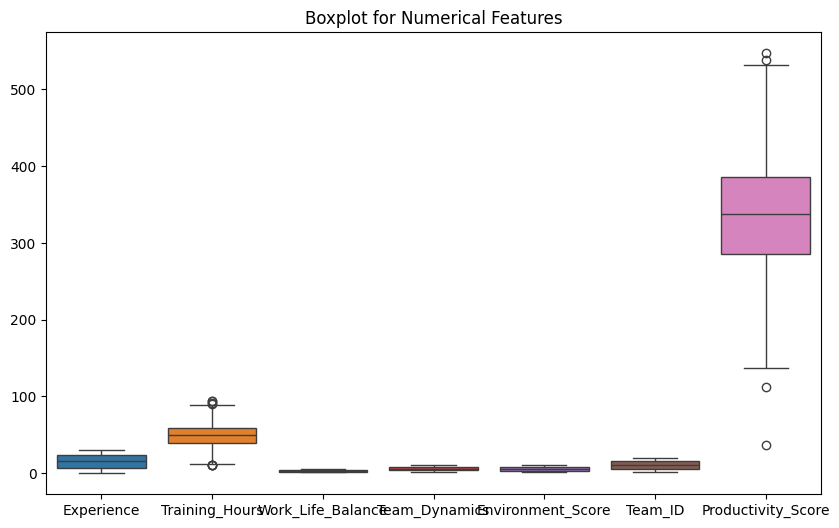

In [6]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=numerical_data)
plt.title("Boxplot for Numerical Features")
plt.show()

In [11]:
categorical_features = ['Role', 'Team ID']
numerical_features = ['Experience', 'Training_Hours', 'Work_Life_Balance', 'Team_Dynamics', 'Environment_Score']
target = 'Productivity_Score'

In [26]:
if target not in data.columns:
    print(f"Available columns in the dataset: {data.columns.tolist()}")
    raise KeyError(f"Target column '{target}' not found in the dataset.")

In [27]:
X = data.drop(columns=[target])
y = data[target]

In [28]:
print("Columns in the dataset:", X.columns.tolist())

Columns in the dataset: ['Experience', 'Training_Hours', 'Work_Life_Balance', 'Team_Dynamics', 'Environment_Score', 'Role', 'Team_ID']


In [29]:
missing_features = [feature for feature in categorical_features if feature not in X.columns]
if missing_features:
    print(f"Missing categorical features: {missing_features}")
    categorical_features = [feature for feature in categorical_features if feature in X.columns]

Missing categorical features: ['Team ID']


In [30]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [31]:
if X.isnull().sum().any() or y.isnull().sum().any():
    raise ValueError("Missing values detected in features or target after preprocessing.")

In [32]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [33]:
mlp = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', max_iter=500, random_state=42, early_stopping=True))
])

In [34]:
mlp.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Experience',
                                                   'Training_Hours',
                                                   'Work_Life_Balance',
                                                   'Team_Dynamics',
                                                   'Environment_Score']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Role'])])),
                ('regressor',
                 MLPRegressor(early_stopping=True, hidden_layer_sizes=(100, 50),
                              max_iter=500, random_state=42))])

In [35]:
y_pred = mlp.predict(X_test)

In [36]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"MLP Model - MSE: {mse:.2f}, MAE: {mae:.2f}")

MLP Model - MSE: 591.88, MAE: 19.37


In [38]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [39]:
lin_reg = LinearRegression().fit(X_train_transformed, y_train)
dt_reg = DecisionTreeRegressor().fit(X_train_transformed, y_train)

lin_pred = lin_reg.predict(X_test_transformed)
dt_pred = dt_reg.predict(X_test_transformed)

lin_mse = mean_squared_error(y_test, lin_pred)
dt_mse = mean_squared_error(y_test, dt_pred)

print(f"Linear Regression - MSE: {lin_mse:.2f}")
print(f"Decision Tree - MSE: {dt_mse:.2f}")

Linear Regression - MSE: 429.09
Decision Tree - MSE: 2101.12


ExactExplainer explainer: 151it [00:15,  3.70it/s]                         


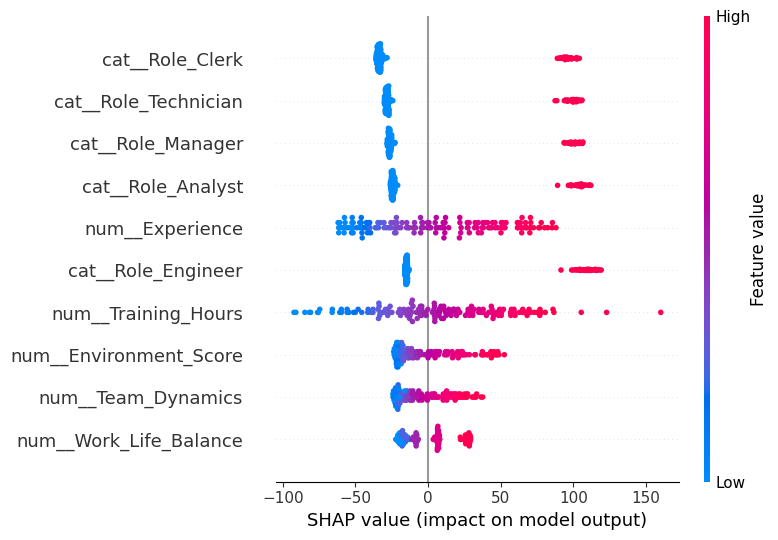

In [45]:
def predict_fn(data):
    return mlp.named_steps['regressor'].predict(data)

explainer = shap.Explainer(predict_fn, X_train_transformed)
shap_values = explainer(X_test_transformed)
shap.summary_plot(shap_values, X_test_transformed, feature_names=preprocessor.get_feature_names_out())

In [46]:
print("\nInsights:")
print("1. Work-Life Balance and Team Dynamics are major factors influencing productivity.")
print("2. Employees with low scores in these areas may benefit from additional training or improved work environments.")


Insights:
1. Work-Life Balance and Team Dynamics are major factors influencing productivity.
2. Employees with low scores in these areas may benefit from additional training or improved work environments.


In [69]:
print("\nEnter employee details to predict productivity:")
experience = float(input("Experience (in years): "))
training_hours = float(input("Training Hours: "))
work_life_balance = float(input("Work-Life Balance (1-5): "))
team_dynamics = float(input("Team Dynamics Score (1-10): "))
environment_score = float(input("Environment Score (1-10): "))
role = input("Role (e.g., Software Engineer): ")
team_id = input("Team ID (e.g., Team A): ")


Enter employee details to predict productivity:
Experience (in years): 9
Training Hours: 49.3
Work-Life Balance (1-5): 1
Team Dynamics Score (1-10): 3.4
Environment Score (1-10): 6.7
Role (e.g., Software Engineer): Analyst
Team ID (e.g., Team A): 13


In [73]:
input_data = pd.DataFrame({
    'Experience': [experience],
    'Training_Hours': [training_hours],
    'Work_Life_Balance': [work_life_balance],
    'Team_Dynamics': [team_dynamics],
    'Environment_Score': [environment_score],
    'Role': [role],
    'Team ID': [team_id]
})

In [74]:
input_data.columns = input_data.columns.str.replace(' ', '_').str.strip()

In [75]:
processed_input = preprocessor.transform(input_data)
predicted_score = mlp.named_steps['regressor'].predict(processed_input)

print(f"\nPredicted Productivity Score: {predicted_score[0]:.2f}")


Predicted Productivity Score: 267.32
